## ✈️ Airline Tweet Sentiment Prediction

Given *tweets about airline experiences*, let's try to classify the **sentiment** of a given tweet (positive/neutral/negative).

We will use Tensorflow ANN (with a GRU) to make our predictions. 

Data source: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

### Importing Libraries

In [5]:
import numpy as np
import pandas as pd

import re
import emoji
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import tensorflow as tf

2025-02-12 12:56:42.829598: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
data = pd.read_csv("Tweets.csv")
data

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [9]:
# Removing low quality data 
confidence_threshold = 0.6
data = data.drop(data.query("airline_sentiment_confidence < @confidence_threshold").index, axis=0).reset_index(drop=True)

In [10]:
tweets_df = pd.concat([data['text'], data['airline_sentiment']], axis=1)
tweets_df

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica I didn't today... Must mean I n...,neutral
2,@VirginAmerica it's really aggressive to blast...,negative
3,@VirginAmerica and it's a really big bad thing...,negative
4,@VirginAmerica seriously would pay $30 a fligh...,negative
...,...,...
14397,@AmericanAir right on cue with the delays👌,negative
14398,@AmericanAir leaving over 20 minutes Late Flig...,negative
14399,@AmericanAir Please bring American Airlines to...,neutral
14400,"@AmericanAir you have my money, you change my ...",negative


### Preprocessing

In [11]:
tweets_df.isna().sum()

text                 0
airline_sentiment    0
dtype: int64

In [12]:
tweets_df['airline_sentiment'].value_counts()

airline_sentiment
negative    9113
neutral     2997
positive    2292
Name: count, dtype: int64

In [13]:
sentiment_ordering = ['negative', 'neutral', 'positive']

tweets_df['airline_sentiment'] = tweets_df['airline_sentiment'].apply(lambda x: sentiment_ordering.index(x))

In [14]:
tweets_df

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica I didn't today... Must mean I n...,1
2,@VirginAmerica it's really aggressive to blast...,0
3,@VirginAmerica and it's a really big bad thing...,0
4,@VirginAmerica seriously would pay $30 a fligh...,0
...,...,...
14397,@AmericanAir right on cue with the delays👌,0
14398,@AmericanAir leaving over 20 minutes Late Flig...,0
14399,@AmericanAir Please bring American Airlines to...,1
14400,"@AmericanAir you have my money, you change my ...",0


In [15]:
emoji.demojize('@AmericanAir right on cue with the delays👌')

'@AmericanAir right on cue with the delays:OK_hand:'

In [16]:
ps = PorterStemmer() # stemming of words
ps.stem('happening')

'happen'

In [19]:
# regex101.com 
def process_tweet(tweet):
    new_tweet = tweet.lower()
    new_tweet = re.sub(r'@\w+', '', new_tweet) # Remove @s
    new_tweet = re.sub(r'#', '', new_tweet) # Remove #s
    new_tweet = re.sub(r':', ' ', emoji.demojize(new_tweet))  # Turn emojis into words
    new_tweet = re.sub(r'http\S+', '', new_tweet) #remove urls
    new_tweet = re.sub(r'\$\S+', 'dollar', new_tweet) # change dollar amounts to dollar
    new_tweet = re.sub(r'[^a-z0-9\s]', '', new_tweet) # remove punctuation
    new_tweet = re.sub(r'[0-9]+', 'number', new_tweet)  # Change number values to number
    new_tweet = new_tweet.split(" ")
    new_tweet = list(map(lambda x: ps.stem(x), new_tweet))  # stemming the words
    new_tweet = list(map(lambda x: x.strip(), new_tweet))  # stripping whitespace from the words
    if '' in new_tweet:
        new_tweet.remove('')
    return new_tweet

In [20]:
tweets = tweets_df['text'].apply(process_tweet)

labels = np.array(tweets_df['airline_sentiment'])

In [21]:
tweets

0                                           [what, , said]
1        [i, didnt, today, must, mean, i, need, to, tak...
2        [it, realli, aggress, to, blast, obnoxi, enter...
3         [and, it, a, realli, big, bad, thing, about, it]
4        [serious, would, pay, dollar, a, flight, for, ...
                               ...                        
14397           [right, on, cue, with, the, delay, hand, ]
14398    [leav, over, number, minut, late, flight, no, ...
14399    [pleas, bring, american, airlin, to, blackberr...
14400    [you, have, my, money, you, chang, my, flight,...
14401    [we, have, number, ppl, so, we, need, number, ...
Name: text, Length: 14402, dtype: object

In [22]:
# Get size of vocabulary
vocabulary = set()

for tweet in tweets:
    for word in tweet:
        if word not in vocabulary:
            vocabulary.add(word)

vocab_length = len(vocabulary)

# Get max sequence of a length
max_seq_length = 0

for tweet in tweets:
    if len(tweet) > max_seq_length:
        max_seq_length = len(tweet)

# Print results
print("Vocab Length: ", vocab_length)
print("Max Sequence Length: ", max_seq_length)

Vocab Length:  11250
Max Sequence Length:  90


In [23]:
tokenizer = Tokenizer(num_words=vocab_length)
tokenizer.fit_on_texts(tweets)

sequences = tokenizer.texts_to_sequences(tweets)
word_index = tokenizer.word_index

model_inputs = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

In [24]:
sequences

[[49, 2, 218],
 [5, 191, 102, 742, 355, 5, 62, 1, 113, 151, 179],
 [15, 138, 2841, 1, 2010, 3424, 773, 14, 17, 1729, 998, 66, 59, 19, 476, 2196],
 [11, 15, 7, 138, 460, 213, 288, 85, 15],
 [418,
  78,
  202,
  109,
  7,
  6,
  9,
  83,
  20,
  191,
  19,
  29,
  4556,
  138,
  3,
  123,
  213,
  288,
  85,
  58,
  1535],
 [175, 1338, 307, 44, 5, 58, 1854, 29, 2446, 4557, 210, 67, 466, 2, 2],
 [138, 105, 7, 2447, 1395, 9, 2842, 327, 2197, 4558, 68, 2, 4559],
 [192, 5, 4560, 39, 5, 40, 2, 1396],
 [15, 23, 334, 11, 206, 42, 32, 350, 17, 177, 140, 1, 18],
 [125, 8, 110, 20, 2011, 13, 3, 506, 1284, 424, 16, 1285, 1469, 1855, 4],
 [5, 1132, 645, 3425, 47, 178, 217, 164, 4561, 4562, 2, 1396],
 [29,
  13,
  529,
  7,
  121,
  356,
  221,
  225,
  85,
  12,
  588,
  179,
  1,
  2,
  66,
  5,
  335,
  128,
  919,
  10,
  12,
  336,
  179,
  253,
  1628],
 [2,
  52,
  58,
  17,
  1629,
  4563,
  980,
  112,
  126,
  113,
  70,
  3,
  999,
  466,
  31,
  114,
  33,
  4564],
 [21],
 [4565, 351, 13,

In [29]:
word_index

{'to': 1,
 '': 2,
 'the': 3,
 'number': 4,
 'i': 5,
 'flight': 6,
 'a': 7,
 'you': 8,
 'for': 9,
 'on': 10,
 'and': 11,
 'my': 12,
 'is': 13,
 'in': 14,
 'it': 15,
 'of': 16,
 'your': 17,
 'me': 18,
 'have': 19,
 'that': 20,
 'thank': 21,
 'get': 22,
 'wa': 23,
 'not': 24,
 'with': 25,
 'at': 26,
 'no': 27,
 'be': 28,
 'thi': 29,
 'but': 30,
 'from': 31,
 'hour': 32,
 'http': 33,
 'can': 34,
 'are': 35,
 'cancel': 36,
 'we': 37,
 'help': 38,
 'now': 39,
 'do': 40,
 'servic': 41,
 'an': 42,
 'delay': 43,
 'time': 44,
 'just': 45,
 'custom': 46,
 'so': 47,
 'been': 48,
 'what': 49,
 'will': 50,
 'call': 51,
 'im': 52,
 'bag': 53,
 'wait': 54,
 'up': 55,
 'plane': 56,
 'out': 57,
 'fli': 58,
 'they': 59,
 'our': 60,
 'hold': 61,
 'need': 62,
 'us': 63,
 'when': 64,
 'how': 65,
 'amp': 66,
 'go': 67,
 'there': 68,
 'if': 69,
 'all': 70,
 'whi': 71,
 'cant': 72,
 'tri': 73,
 'still': 74,
 'one': 75,
 'pleas': 76,
 'airlin': 77,
 'would': 78,
 'day': 79,
 'gate': 80,
 'flightl': 81,
 'back':

In [30]:
model_inputs

array([[  49,    2,  218, ...,    0,    0,    0],
       [   5,  191,  102, ...,    0,    0,    0],
       [  15,  138, 2841, ...,    0,    0,    0],
       ...,
       [  76,  507,  435, ...,    0,    0,    0],
       [   8,   19,   12, ...,    0,    0,    0],
       [  37,   19,    4, ...,    0,    0,    0]], dtype=int32)

In [31]:
model_inputs.shape

(14402, 90)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(model_inputs, labels, train_size=0.7, random_state=22)

### Training

In [33]:
embedding_dim = 32   # through experience

inputs = tf.keras.Input(shape=(max_seq_length, ))

embedding = tf.keras.layers.Embedding(
    input_dim = vocab_length,
    output_dim = embedding_dim, 
    input_length = max_seq_length
)(inputs)

2025-02-12 14:09:40.568822: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [34]:
embedding

<KerasTensor: shape=(None, 90, 32) dtype=float32 (created by layer 'embedding')>

2025-02-12 14:20:14.301271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-12 14:20:14.303981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-12 14:20:14.305593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

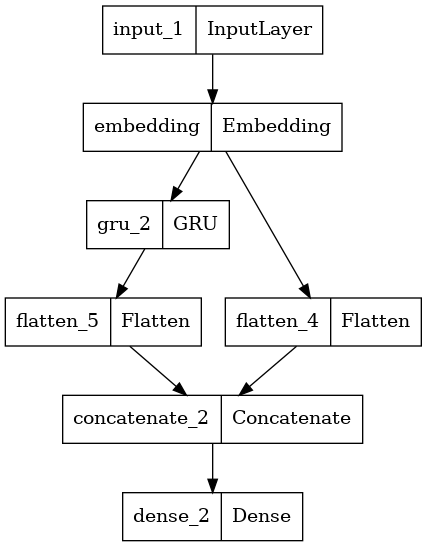

In [39]:
# Model A (Just a Flatten Layer)
flatten = tf.keras.layers.Flatten()(embedding)

# Model B (GRU with a Flatten layer)
gru = tf.keras.layers.GRU(units=embedding_dim)(embedding)
gru_flatten = tf.keras.layers.Flatten()(gru)

# Both A and B are fed into the output
concat = tf.keras.layers.concatenate([flatten, gru_flatten])

outputs = tf.keras.layers.Dense(3, activation='softmax')(concat)

model = tf.keras.Model(inputs, outputs)

tf.keras.utils.plot_model(model)

In [41]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

batch_size = 32
epochs = 100

history = model.fit(
    X_train, 
    y_train,
    validation_split = 0.2,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 3,
            restore_best_weights = True
        ),
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/100


2025-02-12 14:21:55.152593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-12 14:21:55.155433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-12 14:21:55.157722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

251/252 [============================>.] - ETA: 0s - loss: 0.7942 - accuracy: 0.6643   

2025-02-12 14:22:04.202933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-12 14:22:04.205602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-12 14:22:04.207733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

252/252 [==============================] - 10s 29ms/step - loss: 0.7941 - accuracy: 0.6641 - val_loss: 0.6685 - val_accuracy: 0.7268 - lr: 0.0010
Epoch 2/100
252/252 [==============================] - 6s 25ms/step - loss: 0.5231 - accuracy: 0.7994 - val_loss: 0.5416 - val_accuracy: 0.7848 - lr: 0.0010
Epoch 3/100
252/252 [==============================] - 6s 25ms/step - loss: 0.3684 - accuracy: 0.8693 - val_loss: 0.5054 - val_accuracy: 0.7947 - lr: 0.0010
Epoch 4/100
252/252 [==============================] - 6s 24ms/step - loss: 0.2715 - accuracy: 0.9082 - val_loss: 0.5033 - val_accuracy: 0.7987 - lr: 0.0010
Epoch 5/100
252/252 [==============================] - 6s 24ms/step - loss: 0.2017 - accuracy: 0.9381 - val_loss: 0.5144 - val_accuracy: 0.7982 - lr: 0.0010
Epoch 6/100
252/252 [==============================] - 6s 24ms/step - loss: 0.1511 - accuracy: 0.9603 - val_loss: 0.5378 - val_accuracy: 0.7967 - lr: 0.0010
Epoch 7/100
252/252 [==============================] - 6s 24ms/step -

### Results

In [42]:
model.evaluate(X_test, y_test)

136/136 [==============================] - 2s 15ms/step - loss: 0.4919 - accuracy: 0.8042


[0.4919270873069763, 0.8042119741439819]